# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

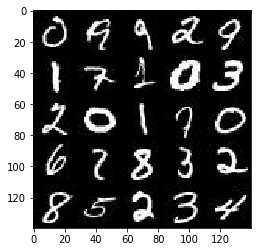

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

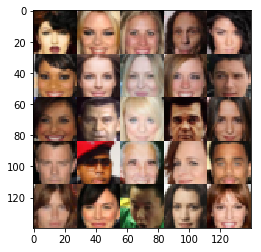

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [18]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding="same")
        relu1 = tf.maximum(alpha*x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        #7x7x64
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        #4x4X128
        
        #x4 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding="same")
        #bn4 = tf.layers.batch_normalization(x4, training=True)
        #relu4 = tf.maximum(alpha*bn4, bn4)
        #2x2X256
        
        #Flatten it
        relu_shape = int(relu3.shape[1]*relu3.shape[2]*relu3.shape[3])
        flat = tf.reshape(relu3, (-1, relu_shape))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*256)
        #Reshape it to start the convolutional stack, 2x2x256
        x1 = tf.reshape(x1, (-1, 2, 2, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding="valid")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        #print(x3.shape)
        
        # Output layer, 32x32x?
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding="same")
        #print(logits.shape)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2
                
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 128 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5475... Generator Loss: 7.8284
Epoch 1/2... Discriminator Loss: 1.9403... Generator Loss: 0.1975
Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 1.3546
Epoch 1/2... Discriminator Loss: 0.8811... Generator Loss: 3.5396
Epoch 1/2... Discriminator Loss: 0.8621... Generator Loss: 0.7464
Epoch 1/2... Discriminator Loss: 0.4212... Generator Loss: 1.5457
Epoch 1/2... Discriminator Loss: 1.6030... Generator Loss: 5.8894
Epoch 1/2... Discriminator Loss: 0.7166... Generator Loss: 5.2739
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.4335
Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 2.2559
Epoch 1/2... Discriminator Loss: 0.6604... Generator Loss: 3.3918
Epoch 1/2... Discriminator Loss: 0.9512... Generator Loss: 0.7136


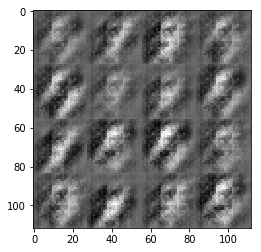

Epoch 1/2... Discriminator Loss: 1.6835... Generator Loss: 0.3588
Epoch 1/2... Discriminator Loss: 0.7125... Generator Loss: 2.1811
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 3.1508
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 2.2541
Epoch 1/2... Discriminator Loss: 1.4732... Generator Loss: 1.1522
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 2.0838
Epoch 1/2... Discriminator Loss: 1.4807... Generator Loss: 1.8288
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 0.8023
Epoch 1/2... Discriminator Loss: 1.1416... Generator Loss: 0.7123
Epoch 1/2... Discriminator Loss: 1.6452... Generator Loss: 2.6249
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 1.3822
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.5009
Epoch 1/2... Discriminator Loss: 1.2383... Generator Loss: 0.5356


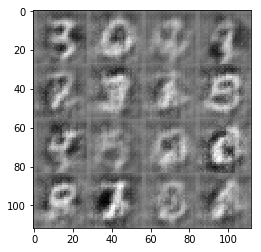

Epoch 1/2... Discriminator Loss: 1.5736... Generator Loss: 0.2946
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 0.6564
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 0.6250
Epoch 1/2... Discriminator Loss: 1.2320... Generator Loss: 1.1839
Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 0.9260
Epoch 1/2... Discriminator Loss: 1.5694... Generator Loss: 0.3105
Epoch 1/2... Discriminator Loss: 1.2232... Generator Loss: 0.5164
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 0.9274
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.3991
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.3264
Epoch 1/2... Discriminator Loss: 1.1096... Generator Loss: 0.6343
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.4264
Epoch 1/2... Discriminator Loss: 1.4556... Generator Loss: 0.3441


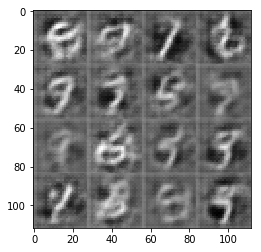

Epoch 1/2... Discriminator Loss: 1.2103... Generator Loss: 0.5112
Epoch 1/2... Discriminator Loss: 1.5881... Generator Loss: 0.2971
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 0.6015
Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 0.4130
Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.6735... Generator Loss: 0.2711
Epoch 1/2... Discriminator Loss: 1.2074... Generator Loss: 0.5283
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.3660
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 0.8581
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.7106
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 1.3591
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 1.3488


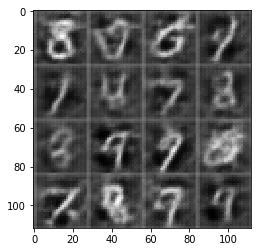

Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 1.4397
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 0.9912
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 1.0855
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 1.0218... Generator Loss: 0.9785
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 0.4871
Epoch 1/2... Discriminator Loss: 1.3982... Generator Loss: 0.3840
Epoch 1/2... Discriminator Loss: 1.1161... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 2.1362... Generator Loss: 0.1659
Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 1.2706
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 1.3386
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 1.0790


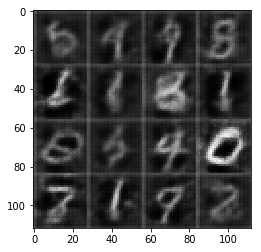

Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 1.4212
Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.8752... Generator Loss: 0.2205
Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 0.7256
Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 0.4632
Epoch 1/2... Discriminator Loss: 0.9404... Generator Loss: 1.2253
Epoch 1/2... Discriminator Loss: 1.1334... Generator Loss: 1.2096
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 1.4933
Epoch 1/2... Discriminator Loss: 1.0213... Generator Loss: 1.1753
Epoch 1/2... Discriminator Loss: 1.4860... Generator Loss: 1.8329
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.3829
Epoch 1/2... Discriminator Loss: 1.1943... Generator Loss: 0.5389


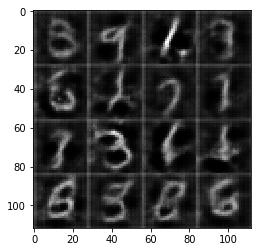

Epoch 1/2... Discriminator Loss: 1.2475... Generator Loss: 0.4658
Epoch 1/2... Discriminator Loss: 1.6747... Generator Loss: 0.2768
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 1.1783
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 1.0509
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 2.0677
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 1.4119
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 1.7674
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.6016
Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 0.4886
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 0.3717
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.5411
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 0.5638
Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 0.8747


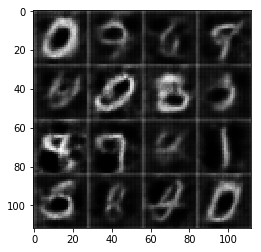

Epoch 1/2... Discriminator Loss: 1.8886... Generator Loss: 0.2119
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 0.7435
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 0.5332
Epoch 2/2... Discriminator Loss: 0.9130... Generator Loss: 1.3410
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 1.2114
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 1.1240... Generator Loss: 0.6444
Epoch 2/2... Discriminator Loss: 2.7799... Generator Loss: 0.0868
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.9527
Epoch 2/2... Discriminator Loss: 0.9648... Generator Loss: 1.4812
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.0276


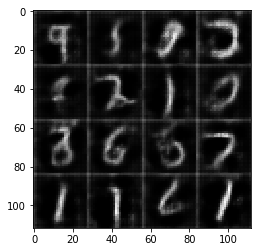

Epoch 2/2... Discriminator Loss: 1.6132... Generator Loss: 2.0804
Epoch 2/2... Discriminator Loss: 0.9077... Generator Loss: 1.0736
Epoch 2/2... Discriminator Loss: 0.9082... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 0.6252
Epoch 2/2... Discriminator Loss: 1.0025... Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.1124
Epoch 2/2... Discriminator Loss: 1.8551... Generator Loss: 0.2369
Epoch 2/2... Discriminator Loss: 1.5568... Generator Loss: 0.2965
Epoch 2/2... Discriminator Loss: 0.8665... Generator Loss: 1.2063
Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 1.2865
Epoch 2/2... Discriminator Loss: 1.1297... Generator Loss: 1.5505
Epoch 2/2... Discriminator Loss: 0.9300... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 0.8610


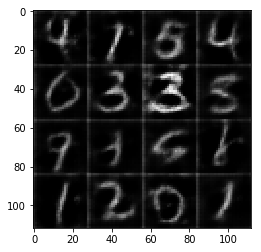

Epoch 2/2... Discriminator Loss: 1.1320... Generator Loss: 0.5406
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 1.2423
Epoch 2/2... Discriminator Loss: 1.5806... Generator Loss: 2.6527
Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 0.4671
Epoch 2/2... Discriminator Loss: 1.5588... Generator Loss: 0.3042
Epoch 2/2... Discriminator Loss: 1.8143... Generator Loss: 0.2379
Epoch 2/2... Discriminator Loss: 0.7900... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 1.4598... Generator Loss: 0.3628
Epoch 2/2... Discriminator Loss: 1.7966... Generator Loss: 0.2267
Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 0.7440
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 0.8145
Epoch 2/2... Discriminator Loss: 1.0949... Generator Loss: 0.5508
Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 1.4269


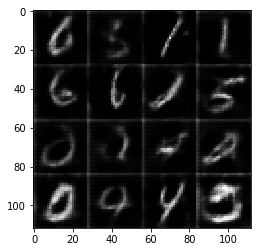

Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 1.5573
Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 1.3067
Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 0.8727
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 1.5116
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 1.3132
Epoch 2/2... Discriminator Loss: 1.7448... Generator Loss: 0.2513
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.4427
Epoch 2/2... Discriminator Loss: 0.7642... Generator Loss: 1.4727
Epoch 2/2... Discriminator Loss: 1.2551... Generator Loss: 1.8200
Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 1.7373
Epoch 2/2... Discriminator Loss: 0.7082... Generator Loss: 1.2456
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 2.3756


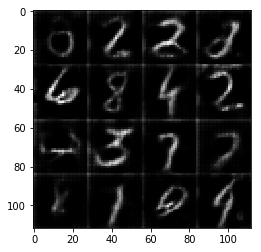

Epoch 2/2... Discriminator Loss: 1.7833... Generator Loss: 0.2505
Epoch 2/2... Discriminator Loss: 1.5360... Generator Loss: 0.3063
Epoch 2/2... Discriminator Loss: 0.7280... Generator Loss: 1.0762
Epoch 2/2... Discriminator Loss: 1.1339... Generator Loss: 1.6846
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 0.7282
Epoch 2/2... Discriminator Loss: 1.6608... Generator Loss: 0.2720
Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 0.5323
Epoch 2/2... Discriminator Loss: 1.5594... Generator Loss: 0.3124
Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 1.2356
Epoch 2/2... Discriminator Loss: 1.7595... Generator Loss: 0.2532
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.5492
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 0.9560
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 0.5539


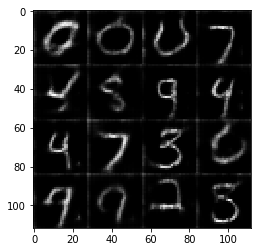

Epoch 2/2... Discriminator Loss: 2.3532... Generator Loss: 3.0966
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.5814
Epoch 2/2... Discriminator Loss: 0.9436... Generator Loss: 2.1677
Epoch 2/2... Discriminator Loss: 1.0366... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 0.6707... Generator Loss: 1.4051
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 1.9840
Epoch 2/2... Discriminator Loss: 1.0576... Generator Loss: 0.5935
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 2.1959
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 0.6174
Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 0.8173
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 2.1801
Epoch 2/2... Discriminator Loss: 0.6436... Generator Loss: 1.5915


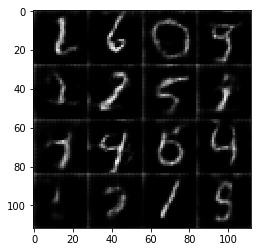

Epoch 2/2... Discriminator Loss: 0.8979... Generator Loss: 1.1288
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 1.8096
Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 0.7388
Epoch 2/2... Discriminator Loss: 1.6674... Generator Loss: 3.6127
Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.0156
Epoch 2/2... Discriminator Loss: 1.5038... Generator Loss: 0.3277
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 1.7646... Generator Loss: 0.2511
Epoch 2/2... Discriminator Loss: 0.7288... Generator Loss: 0.9863
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 0.7566
Epoch 2/2... Discriminator Loss: 3.2793... Generator Loss: 4.5282
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.5970


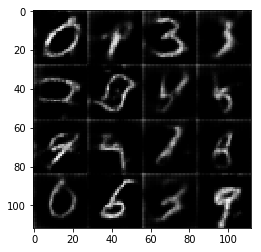

Epoch 2/2... Discriminator Loss: 1.1240... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 0.7307... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 1.5275... Generator Loss: 3.2895
Epoch 2/2... Discriminator Loss: 0.9795... Generator Loss: 0.6720
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 0.7848
Epoch 2/2... Discriminator Loss: 0.9003... Generator Loss: 2.5686
Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 2.0456
Epoch 2/2... Discriminator Loss: 0.9687... Generator Loss: 0.6705


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.5018
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 5.9616
Epoch 1/1... Discriminator Loss: 1.8305... Generator Loss: 0.2160
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 6.2294
Epoch 1/1... Discriminator Loss: 1.6257... Generator Loss: 0.2887
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 1.6739
Epoch 1/1... Discriminator Loss: 1.6663... Generator Loss: 2.0369
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.3340
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.4176
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.3687
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 1.6601


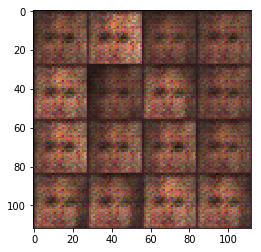

Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 1.5686
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.3844
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.4502
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.3326
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.3215
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.9317


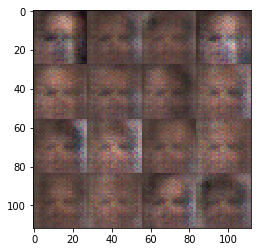

Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.8161... Generator Loss: 0.2773
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 1.8724
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.7065
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 1.7687
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 1.9319
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 2.0957... Generator Loss: 2.0893
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.5045


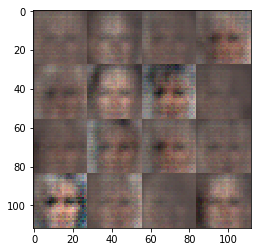

Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 3.0956
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 1.4006
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.5412
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.7763


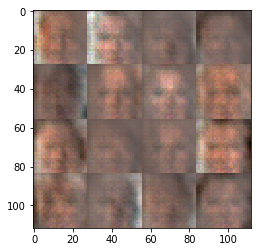

Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 2.4054
Epoch 1/1... Discriminator Loss: 0.6422... Generator Loss: 2.6165
Epoch 1/1... Discriminator Loss: 1.7324... Generator Loss: 0.2639
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 2.3356
Epoch 1/1... Discriminator Loss: 1.7071... Generator Loss: 2.0720
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 2.3403
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 1.9545


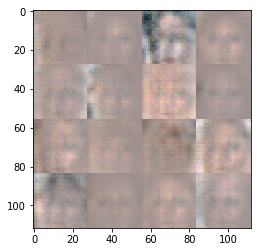

Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 2.4625... Generator Loss: 0.1097
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.8498
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.9250... Generator Loss: 0.2274


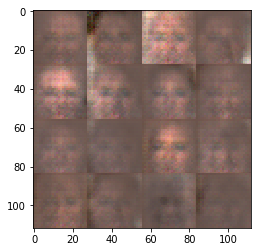

Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 1.5578
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.6170... Generator Loss: 0.3011
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.6918


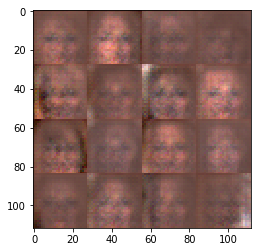

Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.5948... Generator Loss: 0.3834
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 1.2156
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.7845


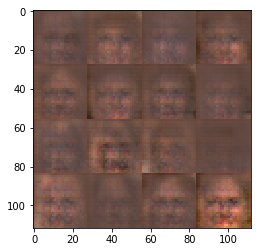

Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 1.3895
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 1.7132
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.5604
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 1.6130... Generator Loss: 0.3276
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.3510
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.6664


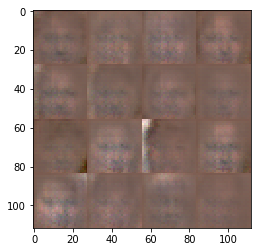

Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.3326
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.0851
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 1.0387


KeyboardInterrupt: 

In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.